# Задача

Заказчик: <br>
Благотворительный фонд “Бюро добрых дел”<br><br>

Основная цель заказчика заключается в том, чтобы из пула тех клиентов, которые жертвовали за последний год, выявить клиентов, которые могут увеличить частоту или размер пожертвований.<br>
* Данные, которыми располагает заказчик, включают в себя историю платежей жертвователей и какую-то дополнительную информацию за несколько лет по четырём тысячам жертвователей.<br>
* Жизненный цикл жертвователя составляет от полутора до трёх лет, поэтому в истории будут примеры того, как именно меняется характер платежей клиентов.<br>
* Если получится на основе данных сделать дополнительную сегментацию, например выделить характерное поведение пользователей, которые прекращают жертвовать, это также интересует заказчика.
<br><br>

Данные реальные, задача интересная, успешное её решение приведёт к тому, что больше людей получат ту помощь, в которой нуждаются.

## Подготовка данных

In [62]:
import pandas as pd
import numpy as np
import warnings

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler #масштабирование признаков

warnings.filterwarnings('ignore')

In [63]:
donors = pd.read_excel('Выгрузка для ЯП_2.xlsx', sheet_name='Доноры')
donats = pd.read_excel('Выгрузка для ЯП_2.xlsx', sheet_name='Пожертвования')

display(donors.head(10), donors.info())
display(donats.head(10), donats.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   ID                               3683 non-null   object        
 1   Пол                              2431 non-null   object        
 2   Город                            1015 non-null   object        
 3   Дата последней email активности  1835 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 115.2+ KB


,ID,Пол,Город,Дата последней email активности
0,AF575B85-917F-475D-8875-00055586E05B,NaN,NaN,NaT
1,229A9B43-3A15-4A48-8CB6-000EDB240D50,NaN,NaN,NaT
2,C6606486-05A8-4437-ACF9-00344E54FEE1,NaN,NaN,NaT
3,6ED86154-A688-4A11-868F-006209035413,Женский ...,NaN,NaT
4,46C41E20-EA56-4698-9C37-00692FD6FFE8,Женский ...,NaN,NaT
5,8CBFF8AB-3153-473A-BE84-0079B873EA33,Мужской ...,NaN,2022-07-18 17:36:39
6,20AC64AC-190E-4091-8D2E-00832BED87C5,Женский ...,NaN,2022-07-18 16:29:53
7,0E516427-6B84-4268-AB70-009E9E1FD026,NaN,NaN,NaT
8,3845EBA8-054E-465D-98CE-00A2758E3F92,NaN,NaN,NaT
9,530A44DC-46A2-48E6-962F-00A67997F7A1,Женский ...,NaN,2022-07-18 16:29:50


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14043 entries, 0 to 14042
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Donor ID            14043 non-null  object        
 1   Дата платежа        14043 non-null  datetime64[ns]
 2   Сумма платежа       14043 non-null  float64       
 3   Рекуррентный        14043 non-null  object        
 4   Назначение платежа  12774 non-null  object        
 5   Канал оплаты        14043 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 658.4+ KB


,Donor ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS
2,D3BEB76D-D8B6-47E2-8109-44F1B278943B,2022-04-07 00:00:00,16.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет
3,F1310736-B229-4AAC-99B7-F13ACECF67CB,2019-12-26 02:25:42,300.0,Нет ...,NaN,SMS
4,61C3D86B-39DA-445C-9D7F-9924CE9BDA14,2021-06-26 01:26:07,200.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты
5,6FDEE73B-0270-4AFA-BA21-579E5B970D6A,2017-08-26 18:16:27,100.0,Да ...,Пожертвование в фонд помощи детям-отказникам и...,Банковские карты
6,F66CEFEF-38BB-4E7A-A795-207E19A03005,2017-06-28 14:15:06,2000.0,Да ...,Пожертвование в фонд помощи детям-отказникам и...,Банковские карты
7,C09905A1-2059-4FAB-B74B-F52B5913CF84,2020-06-01 14:43:58,200.0,Да ...,ПОЖЕРТВОВАНИЕ,Банковские карты
8,BBA4E944-A48D-44B8-A0E6-E4FEB6486097,2021-12-07 17:32:21,500.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты
9,08C3988B-C0FF-44EE-83BF-5A75E18110D2,2019-11-05 20:59:40,100.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты


None

In [64]:
# сравним количество уникальных id в обеих датасетах
display(len(donors['ID'].unique()))
len(donats['Donor ID'].unique())

3683

3683

In [65]:
# т.к. количество уникальных id равны, объединим таблицы в одну,
# предварительно переименовав столбец в donats

donats = donats.rename(columns={'Donor ID' : 'ID'})

df = donats.merge(donors, how='left', on = 'ID')
df.head()

,ID,Дата платежа,Сумма платежа,Рекуррентный,Назначение платежа,Канал оплаты,Пол,Город,Дата последней email активности
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты,Женский ...,Москва,2022-06-03 20:15:57
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,Нет ...,SMS bdd,SMS,Женский ...,Москва,2022-07-18 17:19:02
2,D3BEB76D-D8B6-47E2-8109-44F1B278943B,2022-04-07 00:00:00,16.0,Нет ...,Добровольное пожертвование. НДС не облагается,Прямые поступления на счет,Мужской ...,NaN,NaT
3,F1310736-B229-4AAC-99B7-F13ACECF67CB,2019-12-26 02:25:42,300.0,Нет ...,NaN,SMS,NaN,NaN,NaT
4,61C3D86B-39DA-445C-9D7F-9924CE9BDA14,2021-06-26 01:26:07,200.0,Да ...,ПОЖЕРТВОВАНИЕ undefined,Банковские карты,Женский ...,NaN,2022-07-20 20:32:37


In [66]:
# переименуем столбцы, приведя их к змеиному регистру
df = df.rename(columns = 
              {
                  'ID':'id',
                  'Дата платежа':'date',
                  'Сумма платежа':'amount',
                  'Пол':'gender',
                  'Город':'city',
                  'Назначение платежа' : 'purpose',
                  'Рекуррентный' : 'is_reccurent',
                  'Канал оплаты' : 'channel',
                  'Дата последней email активности': 'last_email_activity'
                  
              }
              )
df.columns

Index(['id', 'date', 'amount', 'is_reccurent', 'purpose', 'channel', 'gender',
       'city', 'last_email_activity'],
      dtype='object')

In [67]:
# приведем данные в столбце 'purpose' к нижнему регистру
df['purpose'] = df['purpose'].str.lower()
(df['purpose'].head()).to_frame()

,purpose
0,пожертвование undefined
1,sms bdd
2,добровольное пожертвование. ндс не облагается
3,NaN
4,пожертвование undefined


In [68]:
# посмотрим процентное соотношение пропусков
df.isna().sum()/len(df['id'])

id                     0.000000
date                   0.000000
amount                 0.000000
is_reccurent           0.000000
purpose                0.090437
channel                0.000000
gender                 0.111799
city                   0.520188
last_email_activity    0.211493
dtype: float64

In [69]:
# заполним пропуски нулями 
df[['purpose','gender','city']] = df[['purpose','gender','city']].fillna('0')
df.isna().sum()/len(df['id'])

id                     0.000000
date                   0.000000
amount                 0.000000
is_reccurent           0.000000
purpose                0.000000
channel                0.000000
gender                 0.000000
city                   0.000000
last_email_activity    0.211493
dtype: float64

In [70]:
# проверим наличие дубликатов
print(df.duplicated().sum())
#df[df.duplicated() == True]

12


In [71]:
# удалим дубликаты
df = df.drop_duplicates()
df.duplicated().sum()

0

In [72]:
# в столбце 'is_reccurent' содержатся значения со множеством пробелов
# заменим их на более удобные знчения 1 и 0
df['is_reccurent'] = df['is_reccurent'].replace('Да                                                                                                                                                                                                                                                        ',
                                                 1)
df['is_reccurent'] = df['is_reccurent'].replace('Нет                                                                                                                                                                                                                                                       ',
                                                  0)

In [73]:
# удалим такие же пробелы в столбце 'gender'
df['gender'] = df['gender'].str.strip()
df['gender'] = df['gender'].str.lower()
df['gender'].unique()

array(['женский', 'мужской', '0'], dtype=object)

In [74]:
# удалим пробелы в столбце 'channel' и приведем значения к нижнему регистру
df['channel'] = df['channel'].str.strip()
df['channel'] = df['channel'].str.lower()

df['channel'].unique()

array(['банковские карты', 'sms', 'прямые поступления на счет',
       'наличные в кассу'], dtype=object)

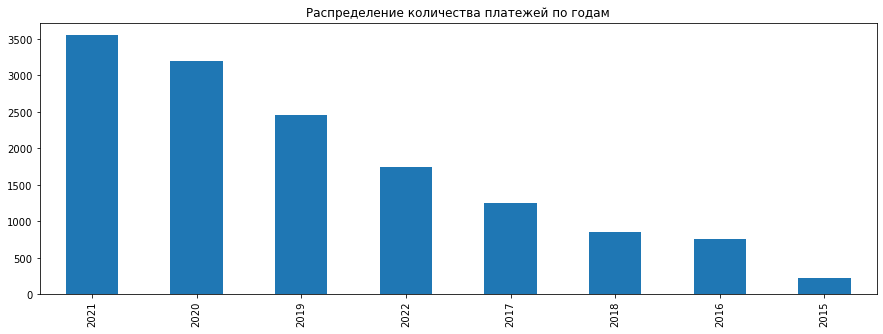

In [75]:
# добавим столбцы с годом, месяцем, датой, номером дня недели платежа
#df['day'] = df['date'].dt.day
#df['weekday'] = df['date'].dt.weekday
#df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
#df['day_of_week'] = df['date'].dt.day_of_week
#удалим столбец с датой
#df = df.drop('date',axis=1)

# количество платежей по годам
df['year'].value_counts().plot(title='Распределение количества платежей по годам', kind='bar', figsize=(15,5));

<AxesSubplot:title={'center':'Зависимость общей суммы пожертвовай от года'}, xlabel='year'>

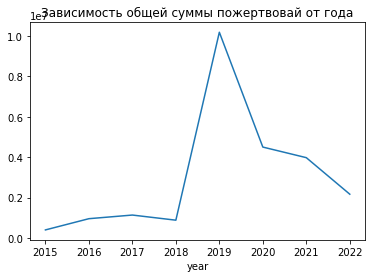

In [76]:

df.groupby('year')['amount'].sum().plot(title='Зависимость общей суммы пожертвовай от года')

In [77]:
# работа с графиками
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#sns.scatterplot(data = df.groupby('year')['amount'].sum())#, style='recurrentis')
#plt.show()

**Вывод:**  В нашем распоряжении информация о 14043 пожертвований<br>
 Уникальных пользователей (ID): 3683 <br>
 Удалены дубликаты.<br>
 Пропуски заменены нулями.<br>
 Категорезированы назначения пожертвований.<br>
 Большое количество пожертвований наблюдается начиная с 2019 года. Целесообразно взять этот период для дальнейшей работы. <br>


## Исследуем пользователей, совершивших повторные пожертвования

### Выделим в отдельный датасет

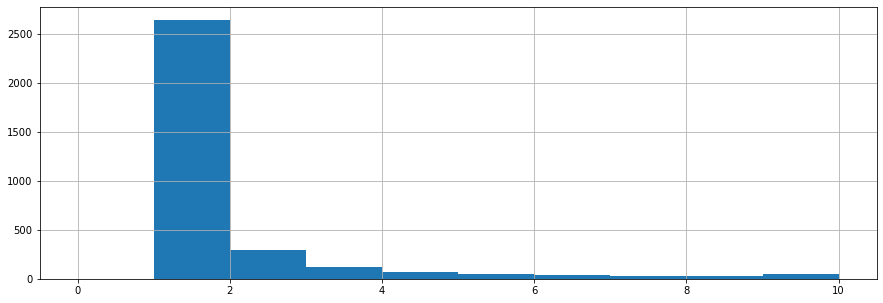

In [78]:
# Сохраним информацию о пользователях, совершивших более одного платежа, в отдельный датасет
# 1. Вычислим количество платежей от одинаковых ID
df1 = df.groupby('id')['id'].count().sort_values(ascending=False)
df1.hist(figsize=(15,5), range=(0,10), bins=10);

**Вывод:**  Среди всех пользователей значительно преобладают жертвователи, совершившие два платежа.<br>

In [79]:
# 2. вычислим количество пользователей, совершивших более одного платежа
(df1>1).sum()

1039

In [80]:
# 3. сохраним ID этих пользователей
repeat = df['id'].value_counts().head(1039).index.tolist()
# 4. сохраним всю информацию о платежах от этих пользователей в датасет
df1 = df[df['id'].isin(repeat)]

df1.head()

,id,date,amount,is_reccurent,purpose,channel,gender,city,last_email_activity,year
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,1,пожертвование undefined,банковские карты,женский,Москва,2022-06-03 20:15:57,2022
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,0,sms bdd,sms,женский,Москва,2022-07-18 17:19:02,2020
2,D3BEB76D-D8B6-47E2-8109-44F1B278943B,2022-04-07 00:00:00,16.0,0,добровольное пожертвование. ндс не облагается,прямые поступления на счет,мужской,0,NaT,2022
4,61C3D86B-39DA-445C-9D7F-9924CE9BDA14,2021-06-26 01:26:07,200.0,1,пожертвование undefined,банковские карты,женский,0,2022-07-20 20:32:37,2021
5,6FDEE73B-0270-4AFA-BA21-579E5B970D6A,2017-08-26 18:16:27,100.0,1,пожертвование в фонд помощи детям-отказникам и...,банковские карты,женский,0,2022-07-18 16:29:38,2017


## Исследуем и категоризируем данные о постоянных жертвователях

In [81]:
# количество пожертвований от постоянных жертвователей
df1['id'].count()

11387

In [82]:
# среднее количество пожертвований от постоянных жертвователей за все время
df1['id'].count()/len(df1['id'].unique())

10.959576515880654

In [83]:
# доля рекуррентных платежей
(df1[df1['is_reccurent'] == 1]['id'].count()/len(df1['id']))

0.7083516290506718

###  Каналы платежей

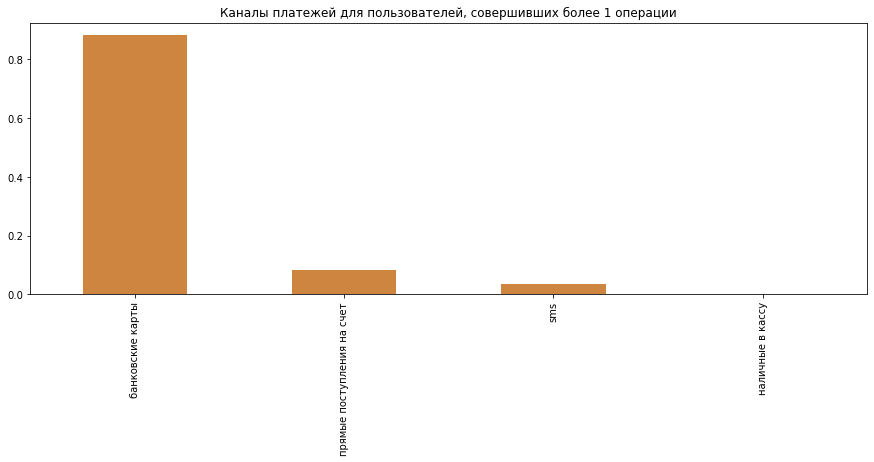

In [84]:
# доля платежей из разных каналов для повторных пожертвований
(df1['channel'].value_counts()/len(df1['id'])).plot(
    title='Каналы платежей для пользователей, совершивших более 1 операции',
    kind='bar', 
    figsize=(15,5),
    color='peru'
);

In [85]:
(df1['channel'].value_counts()/len(df1['id'])).to_frame()

,channel
банковские карты,0.881532
прямые поступления на счет,0.082023
sms,0.036182
наличные в кассу,0.000263


###  Города постоянных жертвователей

In [86]:
# количество городов в датасете
len(df1['city'].unique())

120

In [87]:
# топ городов по количеству постоянных жертвователей

(df1['city'].value_counts()/len(df1['id'])).head(20)

0                    0.452270
Москва               0.303065
Санкт-Петербург      0.039782
Краснодар            0.018530
Якутск               0.011329
Мытищи               0.008167
Екатеринбург         0.007728
Самара               0.007640
Frankfurt am Main    0.007289
Изобильный           0.006674
Сочи                 0.006586
Ростов-на-Дону       0.006586
Одинцово             0.006147
Нижний Новгород      0.005884
Брянск               0.004742
Воронеж              0.004391
Charleston           0.004303
Казань               0.004128
Владивосток          0.003513
Ставрополь           0.003425
Name: city, dtype: float64

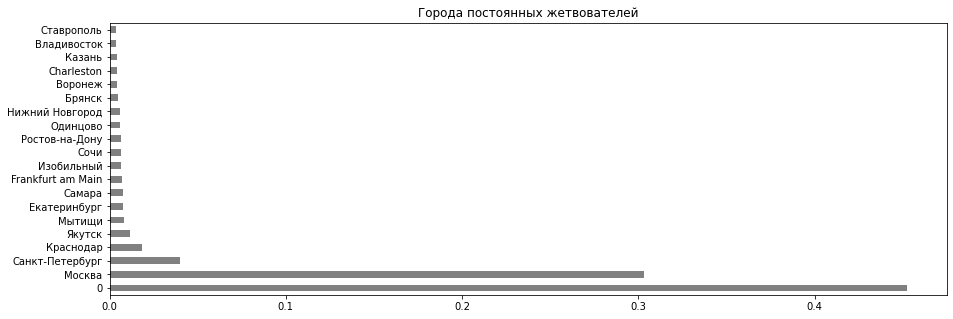

In [88]:
(df1['city'].value_counts()/len(df1['id'])).head(20).plot(
    title='Города постоянных жетвователей',
    kind='barh', 
    figsize=(15,5),
    color='gray'
);

In [89]:
# Напишем функцию для категоризации городов

def city_category(city):
    foreign_cities = ['Frankfurt am Main', 'Charleston', 'Helsinki', 'Juba', 'Copenhagen', 'Holon', 
                     'Hyderabad', 'Alameda', 'Jakarta', 'Keighley', 'Southall', 'Denver']
    
    if city.loc['city'] == 'Москва':
        return 'Москва'
    elif city.loc['city'] == 'Санкт-Петербург':
        return 'Санкт-Петербург'
    elif city.loc['city'] in foreign_cities:
        return 'Зарубежные страны'
    elif city.loc['city'] == '0':
        return 'Город неизвестен'
    else:
        return 'Другие города России'

df1['city'] = df1['city'].fillna(0)
# применим функцию
df1['city_category'] = df1.apply(city_category, axis=1)
# удалим столбец 'city'
df1 = df1.drop('city',axis=1)

df1.head()

,id,date,amount,is_reccurent,purpose,channel,gender,last_email_activity,year,city_category
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,1,пожертвование undefined,банковские карты,женский,2022-06-03 20:15:57,2022,Москва
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,0,sms bdd,sms,женский,2022-07-18 17:19:02,2020,Москва
2,D3BEB76D-D8B6-47E2-8109-44F1B278943B,2022-04-07 00:00:00,16.0,0,добровольное пожертвование. ндс не облагается,прямые поступления на счет,мужской,NaT,2022,Город неизвестен
4,61C3D86B-39DA-445C-9D7F-9924CE9BDA14,2021-06-26 01:26:07,200.0,1,пожертвование undefined,банковские карты,женский,2022-07-20 20:32:37,2021,Город неизвестен
5,6FDEE73B-0270-4AFA-BA21-579E5B970D6A,2017-08-26 18:16:27,100.0,1,пожертвование в фонд помощи детям-отказникам и...,банковские карты,женский,2022-07-18 16:29:38,2017,Город неизвестен


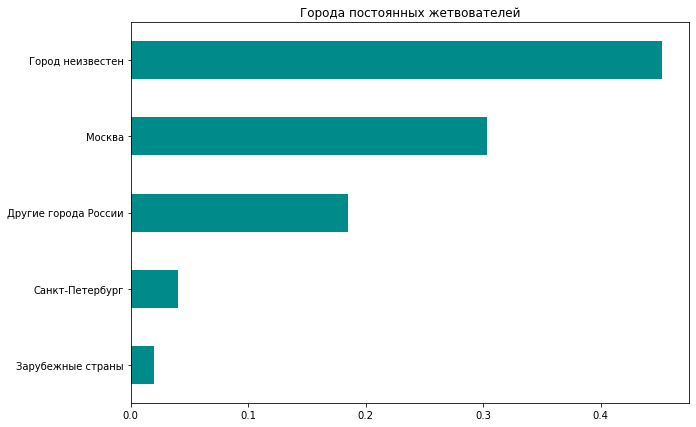

In [90]:
(df1['city_category'].value_counts(ascending=True)/len(df1['id'])).head(20).plot(
    title='Города постоянных жетвователей',
    kind='barh', 
    figsize=(10,7),
    color='darkcyan'
);

### Назначения пожертвований

In [91]:
# назначение пожертвования
# количество уникальных назначений
len(df['purpose'].unique())

880

<AxesSubplot:>

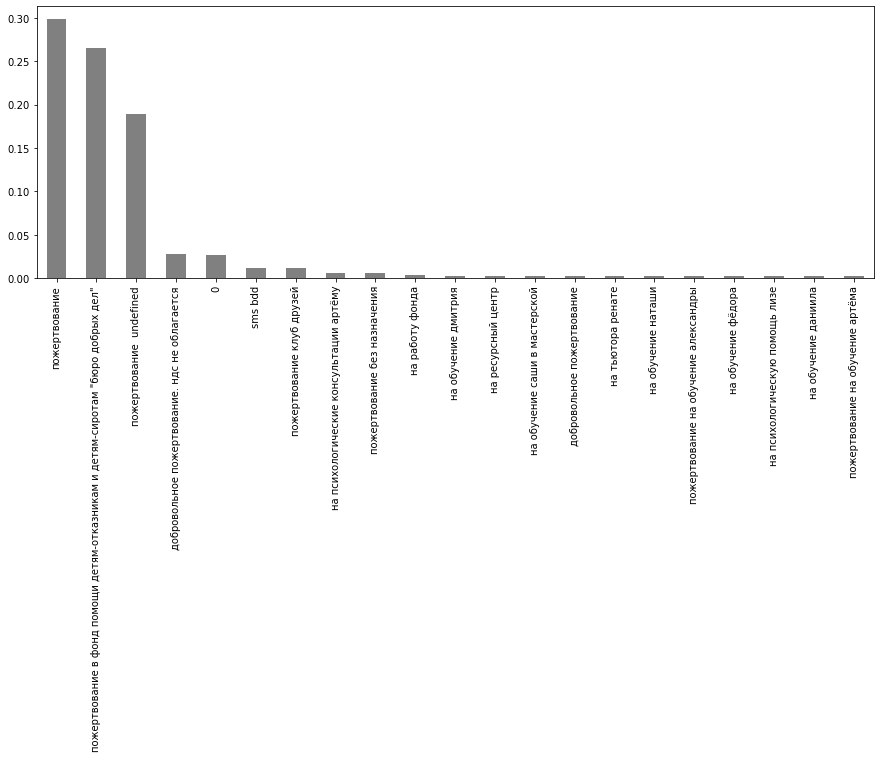

In [92]:
# доли назначений платежей
(df1['purpose'].value_counts()/len(df1['id'])).head(21).plot(kind='bar',figsize=(15,5), color='gray')

In [93]:
# доля назначений пожертвований
((df1['purpose'].value_counts()/len(df1['id'])).head(21)).to_frame()

,purpose
пожертвование,0.298235
"пожертвование в фонд помощи детям-отказникам и детям-сиротам ""бюро добрых дел""",0.265742
пожертвование undefined,0.189514
добровольное пожертвование. ндс не облагается,0.027400
0,0.026961
sms bdd,0.012295
пожертвование клуб друзей,0.011153
на психологические консультации артёму,0.006499
пожертвование без назначения,0.005796
на работу фонда,0.003161


In [94]:
# изменим тип данных в столбце 'purpose' на object
df1['purpose'] = df1['purpose'].astype('object')

In [95]:
# Напишем функцию для категоризации назначений платежей

def purose_category(purpose):
    
    if ('окно в мир' or 'история успеха' or 'на обучение' or 'на тьютора' or 'на психологическую помощь') in purpose.loc['purpose']:
        return 'именное пожертвование'
    elif 'sms' in purpose.loc['purpose']:
        return 'sms'
    elif 'клуб друзей' in purpose.loc['purpose']:
        return 'пожертвование'
    elif '0' in purpose.loc['purpose']:
        return 'назнчение не указано'
    else:
        return 'пожертвование'

# применим функцию
df1['purpose_category'] = df1.apply(purose_category, axis=1)
# удалим столбец 'purpose'
df1 = df1.drop('purpose',axis=1)

df1.head()

,id,date,amount,is_reccurent,channel,gender,last_email_activity,year,city_category,purpose_category
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,1,банковские карты,женский,2022-06-03 20:15:57,2022,Москва,пожертвование
1,81CD4BEF-443E-4D36-B34F-664E11182D65,2020-03-14 12:20:02,300.0,0,sms,женский,2022-07-18 17:19:02,2020,Москва,sms
2,D3BEB76D-D8B6-47E2-8109-44F1B278943B,2022-04-07 00:00:00,16.0,0,прямые поступления на счет,мужской,NaT,2022,Город неизвестен,пожертвование
4,61C3D86B-39DA-445C-9D7F-9924CE9BDA14,2021-06-26 01:26:07,200.0,1,банковские карты,женский,2022-07-20 20:32:37,2021,Город неизвестен,пожертвование
5,6FDEE73B-0270-4AFA-BA21-579E5B970D6A,2017-08-26 18:16:27,100.0,1,банковские карты,женский,2022-07-18 16:29:38,2017,Город неизвестен,пожертвование


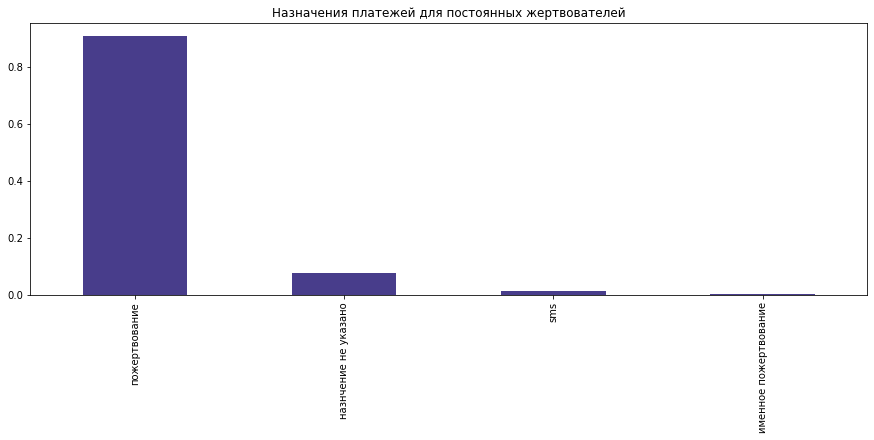

In [96]:
# Назначения платежей
(df1['purpose_category'].value_counts()/len(df1['id'])).head(21).plot(title='Назначения платежей для постоянных жертвователей', kind='bar',figsize=(15,5), color='darkslateblue');

In [97]:
(df1['purpose_category'].value_counts()/len(df1['id'])).to_frame()

,purpose_category
пожертвование,0.909809
назнчение не указано,0.074647
sms,0.012295
именное пожертвование,0.003249


**Вывод:**  Более 90% составляют пожертвования на общие цели.<br>
Именные пожертвования составляют околок 0,3%.

**Размеры пожертвований**

<AxesSubplot:>

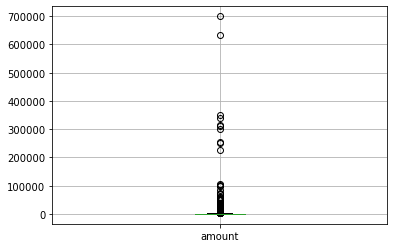

In [98]:
df1.boxplot('amount')

In [99]:
df1['amount'].describe().to_frame()

,amount
count,11387.000000
mean,1322.645681
std,12322.238442
min,0.160000
25%,200.000000
50%,500.000000
75%,1000.000000
max,700000.000000


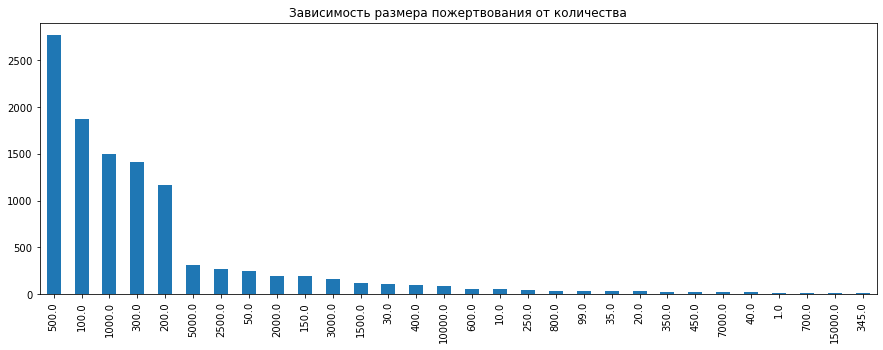

In [100]:
# размеры пожертвований
df1['amount'].value_counts().head(30).plot(title='Зависимость размера пожертвования от количества', kind='bar',figsize=(15,5));

**Вывод:**  Чаще всего жертвуют 500, 100, 1000, 300 или 200 руб.

In [101]:
# удалим пожертвования, сумма которых менее 10 рублей
print('Доля удаленных значений: ', df1[df1['amount']<10]['id'].count()/len(df1['id']))
df1 = df1[df1['amount']>=10]

Доля удаленных значений:  0.004742249934135418


In [102]:
# максимальная сумма рекуррентных платежей -- 10 000 руб
print(df1[(df1['amount']>=10000)&(df['is_reccurent']==1)]['id'].count())
df1[(df1['amount']>=10000)&(df['is_reccurent']==1)].head()

57


,id,date,amount,is_reccurent,channel,gender,last_email_activity,year,city_category,purpose_category
116,2AA1C086-BF4C-4A5B-9237-FCB7BAB3B038,2019-03-28 16:20:08,10000.0,1,банковские карты,женский,2022-07-20 01:16:23,2019,Москва,пожертвование
163,674584A9-FF35-463B-A607-DBB2A7B7891F,2016-11-14 08:35:09,10000.0,1,банковские карты,женский,2020-04-15 22:04:54,2016,Город неизвестен,пожертвование
206,2AA1C086-BF4C-4A5B-9237-FCB7BAB3B038,2019-12-28 16:19:46,10000.0,1,банковские карты,женский,2022-07-20 01:16:23,2019,Москва,пожертвование
289,2AA1C086-BF4C-4A5B-9237-FCB7BAB3B038,2021-11-01 16:33:55,10000.0,1,банковские карты,женский,2022-07-20 01:16:23,2021,Москва,пожертвование
309,2AA1C086-BF4C-4A5B-9237-FCB7BAB3B038,2019-08-28 16:19:56,10000.0,1,банковские карты,женский,2022-07-20 01:16:23,2019,Москва,пожертвование


**Вывод:** Максимальная сумма рекуррентных платежей -- 10 000 руб.<br>
Количество платежей за все время: 57.<br>
Все платежи, город которых известен, совершены из Москвы.

Количество удаленных значений:  24
Доля удаленных значений:  0.002117709344392482


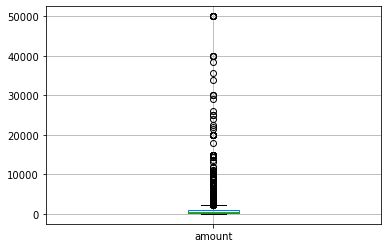

In [103]:
# удалим суммы пожертвований более 50 000 руб
print('Количество удаленных значений: ', (df1[df1['amount']>50000])['id'].count())
print('Доля удаленных значений: ', (df1[df1['amount']>50000])['id'].count()/len(df1['id']))
df1 = df1[df1['amount']<=50000]
df1.boxplot('amount');

# Отдельный датасет с информацией о каждом жертвователе, совершившем более одного пожертвования
В датасет добавим следующие столбцы:
* продолжительность пожертвований (lifetime) в днях;
* среднюю частоту пожертвований;
* средний период пожертвований;
* количество дней, прошедшее с первого платежа;
* количество дней, прошедшее с последнего платежа;
* количество дней, прошедшее с момента последней email активности;



In [104]:
# сформируем отдельный датасет с информацией о каждом жертвователе

df_id = df1.groupby('id').agg(
    {'date': ['min', 'max'], 
     'amount':['count', 'sum', 'mean', 'median'],
     'last_email_activity':'max',
     'is_reccurent':'max'
    }).set_axis(
    ['first_date', 'last_date',
     'donations_count','donations_sum', 'donations_mean', 'donations_median', 
    'last_email_activity',
    'is_reccurent'], 
    axis=1, inplace=False).reset_index()

# вычислим lifetime каждого жертвователя в днях
df_id['lifetime'] = (df_id['last_date']-df_id['first_date'])/np.timedelta64(1,'D')
df_id['lifetime'] = df_id['lifetime'].astype(float).apply(np.floor)
# оставим жертвователей с lifetime > 1
df_id = df_id[df_id['lifetime']>1]

# вычислим частоту пожертвований
#df_id['frequence'] = df_id['donations_count']/df_id['lifetime']
# вычислим, через какое время (в днях) в среднем совершается пожертвование (среднее значение периода пожертвований)
df_id['period'] = df_id['lifetime']/df_id['donations_count']

# добавим количество дней, прошедшее с первого и последнего пожертвований
df_id['first_donation'] = (pd.Timestamp('today') - df_id['first_date'])/np.timedelta64(1,'D')
df_id['last_donation'] = (pd.Timestamp('today') - df_id['last_date'])/np.timedelta64(1,'D')

# добавим столбец с количеством дней с момента последней email активности
df_id['last_email_activity'] = pd.to_datetime(df_id['last_email_activity'])
df_id['last_email_activity'] = (pd.Timestamp('today') - df_id['last_email_activity'])/np.timedelta64(1, 'D')

# добавим столбецы с средним значением чека за следующие периоды:
# sum1 - первые полгода lifetime
# sum2 - последние полгода lifetime
#df_id['sum1'] = 
#df_id['sum2'] = 


# добавим столбецы с количеством платежей за следующие периоды:
# count1 - первые полгода lifetime
# count2 - последние полгода lifetime

# дата окончания первого полугодия lifetime
df_id['lt_1'] = df_id['first_date'] + pd.Timedelta('182 day')

# дата начала последнего полугодия lifetime
df_id['lt_2'] = df_id['last_date'] - pd.Timedelta('182 day')

# заполним пропуски нулями
df_id['last_email_activity'] = df_id['last_email_activity'].fillna(0)

# удалим лишние столбцы
#df_id = df_id.drop(['first_date','last_date'], axis=1)


df_id.head(3)

,id,first_date,last_date,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,period,first_donation,last_donation,lt_1,lt_2
0,000711B2-2785-461B-BF5B-5CB7D2CABA20,2020-03-27 08:23:58,2022-06-27 08:24:05,21,10500.0,500.0,500.0,19.497208,1,822.0,39.142857,871.575171,49.575090,2020-09-25 08:23:58,2021-12-27 08:24:05
2,00ADBA34-1EDC-4652-A559-1C0BE379A0DA,2019-09-10 10:34:52,2022-04-13 11:36:54,4,1600.0,400.0,400.0,27.884534,0,946.0,236.500000,1070.484268,124.441189,2020-03-10 10:34:52,2021-10-13 11:36:54
3,00B01874-B85A-4E15-8888-F38CB255FA76,2020-04-26 17:32:44,2020-11-26 17:32:57,7,700.0,100.0,100.0,28.237775,1,214.0,30.571429,841.194083,627.193932,2020-10-25 17:32:44,2020-05-28 17:32:57


In [105]:
#объединим полученный датасет с датасетом с информацие о всех платежах
df5 = df1.merge(df_id, on='id')
df5.head(2)

,id,date,amount,is_reccurent_x,channel,gender,last_email_activity_x,year,city_category,purpose_category,...,donations_mean,donations_median,last_email_activity_y,is_reccurent_y,lifetime,period,first_donation,last_donation,lt_1,lt_2
0,DE5393F9-9585-4057-B7FB-24B69697FC08,2022-07-03 19:49:48,300.0,1,банковские карты,женский,2022-06-03 20:15:57,2022,Москва,пожертвование,...,166.666667,100.0,73.080738,1,550.0,26.190476,593.437416,43.098897,2021-06-30 11:42:20,2022-01-02 19:49:48
1,DE5393F9-9585-4057-B7FB-24B69697FC08,2020-12-30 11:42:20,100.0,1,банковские карты,женский,2022-06-03 20:15:57,2020,Москва,пожертвование,...,166.666667,100.0,73.080738,1,550.0,26.190476,593.437416,43.098897,2021-06-30 11:42:20,2022-01-02 19:49:48


In [106]:
df5 = df5.sort_values(by = 'id')
df5.head(2)

,id,date,amount,is_reccurent_x,channel,gender,last_email_activity_x,year,city_category,purpose_category,...,donations_mean,donations_median,last_email_activity_y,is_reccurent_y,lifetime,period,first_donation,last_donation,lt_1,lt_2
912,000711B2-2785-461B-BF5B-5CB7D2CABA20,2020-08-27 08:24:04,500.0,1,банковские карты,женский,2022-07-27 10:16:14,2020,Город неизвестен,пожертвование,...,500.0,500.0,19.497208,1,822.0,39.142857,871.575171,49.57509,2020-09-25 08:23:58,2021-12-27 08:24:05
907,000711B2-2785-461B-BF5B-5CB7D2CABA20,2020-04-29 08:24:29,500.0,1,банковские карты,женский,2022-07-27 10:16:14,2020,Город неизвестен,пожертвование,...,500.0,500.0,19.497208,1,822.0,39.142857,871.575171,49.57509,2020-09-25 08:23:58,2021-12-27 08:24:05


### Добавление столбцов с разностью среднего чека и количества пожертвований за первое и последнее полугодия lifetime

In [107]:
# добавим количество дней, прошедшее с каждого платежа до первого и последнего полатежа
df5['to_first_donation'] = (df5['date'] - df5['first_date'])/np.timedelta64(1,'D')
df5['to_last_donation'] = (df5['last_date'] - df5['date'])/np.timedelta64(1,'D')

# датасет со всеми платежами за первое полугодие lifetime
df5_lt_1 = df5[df5['to_first_donation'] < 182]
df5_lt_1 = df5_lt_1.groupby('id').agg(
    {'amount': ['count', 'sum']}).set_axis(['count_lt_1', 'total_lt_1'], axis=1, inplace=False).reset_index()

# датасет со всеми платежами за последнее полугодие lifetime
df5_lt_2 = df5[df5['to_last_donation'] < 182]
df5_lt_2 = df5_lt_2.groupby('id').agg(
    {'amount': ['count', 'sum']}).set_axis(['count_lt_2', 'total_lt_2'], axis=1, inplace=False).reset_index()

# объединим таблицы
df5_lt_1 = df5_lt_1.merge(df5_lt_2, on='id')
df5_lt_1

# добавим столбцы, с разностью количеств пожертвований за первое и последнее полугодие lifetime 
# и разностью общей суммы пожертвований
df5_lt_1['count_lt_diff'] = df5_lt_1['count_lt_2'] - df5_lt_1['count_lt_1']
df5_lt_1['total_lt_diff'] = df5_lt_1['total_lt_2'] - df5_lt_1['total_lt_1']

# удалим лишние столбцы
df5_lt_1 = df5_lt_1.drop(['count_lt_1', 'count_lt_2', 'total_lt_1', 'total_lt_2'], axis=1)
df5_lt_1.head()

,id,count_lt_diff,total_lt_diff
0,000711B2-2785-461B-BF5B-5CB7D2CABA20,0,0.0
1,00ADBA34-1EDC-4652-A559-1C0BE379A0DA,0,-200.0
2,00B01874-B85A-4E15-8888-F38CB255FA76,-1,-100.0
3,013339E3-2CA6-4BED-9EFE-37B65E0D4106,-1,-50.0
4,01693E9D-1D01-4F1F-B495-9457B346DB0D,0,-100.0


In [108]:
# объединим с таблицей, содержащей информацию о каждом жертвователе (df_id)
df_id = df_id.merge(df5_lt_1, on='id')

# удалим лишние столбцы
df_id = df_id.drop(['lt_1', 'lt_2'], axis=1)
df_id.head(2)

,id,first_date,last_date,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,period,first_donation,last_donation,count_lt_diff,total_lt_diff
0,000711B2-2785-461B-BF5B-5CB7D2CABA20,2020-03-27 08:23:58,2022-06-27 08:24:05,21,10500.0,500.0,500.0,19.497208,1,822.0,39.142857,871.575171,49.575090,0,0.0
1,00ADBA34-1EDC-4652-A559-1C0BE379A0DA,2019-09-10 10:34:52,2022-04-13 11:36:54,4,1600.0,400.0,400.0,27.884534,0,946.0,236.500000,1070.484268,124.441189,0,-200.0


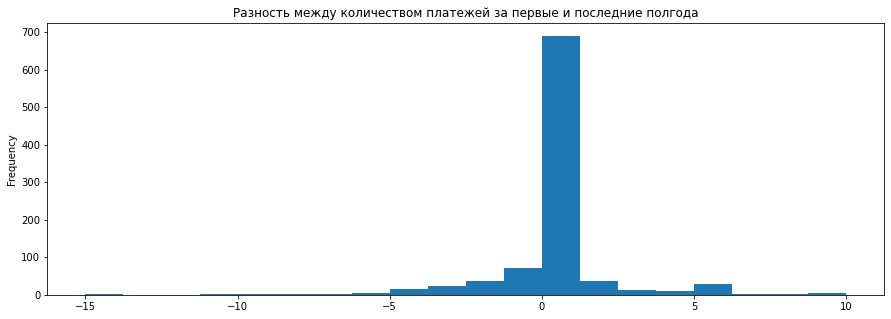

In [109]:
df_id['count_lt_diff'].plot(title='Разность между количеством платежей за первые и последние полгода', kind='hist', figsize=(15,5), bins=20);

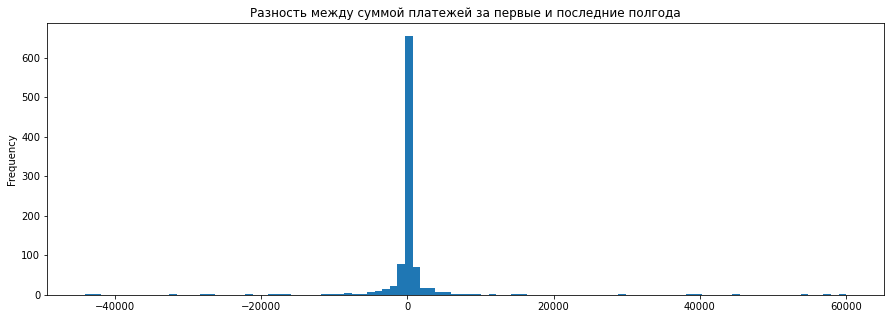

In [110]:
df_id['total_lt_diff'].plot(title='Разность между суммой платежей за первые и последние полгода', kind='hist', figsize=(15,5), bins=100);

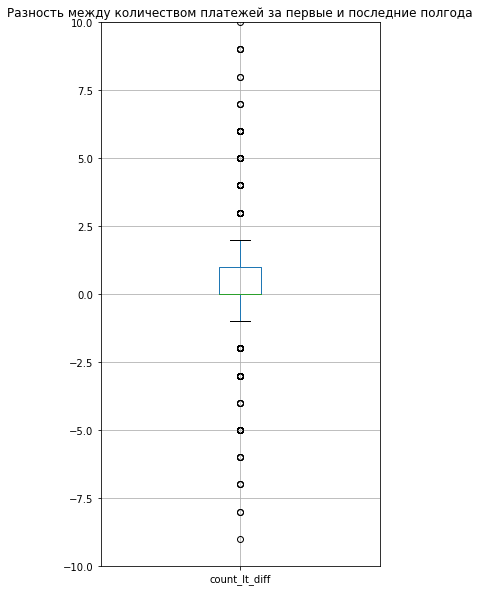

In [111]:
df_id.boxplot(['count_lt_diff'], figsize=(5, 10))
plt.title('Разность между количеством платежей за первые и последние полгода')
plt.ylim(-10,10);

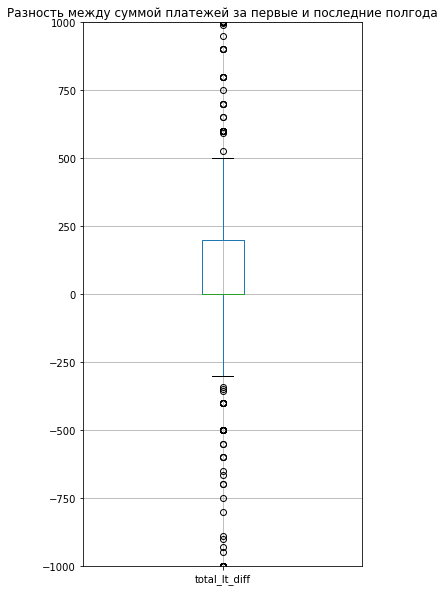

In [112]:
df_id.boxplot(['total_lt_diff'], figsize=(5, 10))
plt.title('Разность между суммой платежей за первые и последние полгода')
plt.ylim(-1000,1000);

### Избавимся от повторов id (обработаем разные типы пожертвований и каналы платежей у одних и тех же жертвователей)

In [113]:
# в датасете с информацией о каждом жертвователе (df_id) встречаются жертвователи, id  которых повторяетя до 4-х раз из-за различных назначений платежей или канаов платежей
# избавимся от повторяющихся строк
# для этого добавим столбцы для каждого типа пожертвования (4) и для каждого назначения платежа (4):

In [114]:
df1['purpose_category'].unique()

array(['пожертвование', 'sms', 'назнчение не указано',
       'именное пожертвование'], dtype=object)

In [115]:
# добавим столбец для каждого типа пожертвований (в датасет со всеми платежами)
df1['пожертвование'] = df1['purpose_category'].apply(lambda x: 1 if (x == 'пожертвование') else 0)
df1['sms_purpose'] = df1['purpose_category'].apply(lambda x: 1 if (x == 'sms') else 0)
df1['именное пожертвование'] = df1['purpose_category'].apply(lambda x: 1 if (x == 'именное пожертвование') else 0)
df1['назнчение не указано'] = df1['purpose_category'].apply(lambda x: 1 if (x == 'назнчение не указано') else 0)

# просуммируем каждый тип пожертвований
df_purpose = df1.groupby('id').agg({'пожертвование':'sum','sms_purpose':'sum','именное пожертвование':'sum','назнчение не указано':'sum'}, axis=1, inplace=False).reset_index()

# объединим полученную таблицу с таблицей с информацией о каждом жертвователе
df_id = df_id.merge(df_purpose, on='id')
df_id.sort_values(by='пожертвование', ascending=False).head(3)

,id,first_date,last_date,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,period,first_donation,last_donation,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано
500,8A8DAECD-40B3-4A41-B53C-06A62BE672E6,2015-11-18 01:20:31,2022-07-02 10:29:51,83,129500.0,1560.240964,1000.0,0.000000,1,2418.0,29.13253,2462.869233,44.487752,1,11500.0,83,0,0,0
42,0B6DA68C-558B-4153-806E-B1D775585B88,2015-12-12 14:50:34,2022-07-03 11:32:28,76,13500.0,177.631579,200.0,28.237798,1,2394.0,31.50000,2438.306698,43.444268,1,800.0,76,0,0,0
270,4ECB767F-8830-497B-B395-851D4EACD1F8,2016-12-25 21:36:52,2022-07-16 12:55:55,65,93500.0,1438.461538,1500.0,28.237983,1,2028.0,31.20000,2059.024546,30.386316,3,7000.0,63,0,2,0


In [116]:
df1['channel'].unique()

array(['банковские карты', 'sms', 'прямые поступления на счет'],
      dtype=object)

In [117]:
# добавим столбец для каждого канала платежей (в датасет со всеми платежами)
df1['банковские карты'] = df1['channel'].apply(lambda x: 1 if (x == 'банковские карты') else 0)
df1['sms_channel'] = df1['channel'].apply(lambda x: 1 if (x == 'sms') else 0)
df1['прямые поступления на счет'] = df1['channel'].apply(lambda x: 1 if (x == 'прямые поступления на счет') else 0)

# просуммируем каждый тип пожертвований
df_channel = df1.groupby('id').agg({'банковские карты':'sum','sms_channel':'sum','прямые поступления на счет':'sum'}, axis=1, inplace=False).reset_index()

# объединим полученную таблицу с таблицей с информацией о каждом жертвователе
df_id = df_id.merge(df_channel, on='id')
df_id.sort_values(by='пожертвование', ascending=False).head(3)

,id,first_date,last_date,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,...,last_donation,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет
500,8A8DAECD-40B3-4A41-B53C-06A62BE672E6,2015-11-18 01:20:31,2022-07-02 10:29:51,83,129500.0,1560.240964,1000.0,0.000000,1,2418.0,...,44.487752,1,11500.0,83,0,0,0,83,0,0
42,0B6DA68C-558B-4153-806E-B1D775585B88,2015-12-12 14:50:34,2022-07-03 11:32:28,76,13500.0,177.631579,200.0,28.237798,1,2394.0,...,43.444268,1,800.0,76,0,0,0,76,0,0
270,4ECB767F-8830-497B-B395-851D4EACD1F8,2016-12-25 21:36:52,2022-07-16 12:55:55,65,93500.0,1438.461538,1500.0,28.237983,1,2028.0,...,30.386316,3,7000.0,63,0,2,0,65,0,0


In [118]:
# вычислим долю каждого назначения пожертвования и каждого канала платежа от общего количества пожертвований для каждого жертвователя
df_id['банковские карты'] = df_id['банковские карты']/df_id['donations_count']
df_id['sms_channel'] = df_id['sms_channel']/df_id['donations_count']
df_id['прямые поступления на счет'] = df_id['прямые поступления на счет']/df_id['donations_count']

df_id['пожертвование'] = df_id['пожертвование']/df_id['donations_count']
df_id['sms_purpose'] = df_id['sms_purpose']/df_id['donations_count']
df_id['именное пожертвование'] = df_id['именное пожертвование']/df_id['donations_count']
df_id['назнчение не указано'] = df_id['назнчение не указано']/df_id['donations_count']


df_id.sort_values(by='банковские карты', ascending=False).head()

,id,first_date,last_date,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,...,last_donation,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет
0,000711B2-2785-461B-BF5B-5CB7D2CABA20,2020-03-27 08:23:58,2022-06-27 08:24:05,21,10500.0,500.0000,500.0,19.497208,1,822.0,...,49.575090,0,0.0,1.0000,0.0,0.0,0.0000,1.0,0.0,0.0
789,D72C9BBA-0EAC-473D-BE6B-DE91EAF9BAB6,2021-06-05 18:03:26,2022-07-28 09:39:02,16,144725.0,9045.3125,5000.0,28.237613,0,417.0,...,18.523041,-1,38625.0,0.9375,0.0,0.0,0.0625,1.0,0.0,0.0
464,82134975-82F3-46CE-A69B-B23471254E60,2020-10-07 22:33:23,2021-02-05 15:33:57,8,4800.0,600.0000,500.0,28.237798,0,120.0,...,556.276571,0,0.0,1.0000,0.0,0.0,0.0000,1.0,0.0,0.0
465,825984A9-4035-4C4D-9B36-48A192E64A43,2020-09-01 17:43:48,2020-11-29 17:45:13,2,6000.0,3000.0000,3000.0,28.237775,0,89.0,...,624.185414,0,0.0,1.0000,0.0,0.0,0.0000,1.0,0.0,0.0
466,827C2407-B3D5-4725-97C6-342629BE7E44,2019-12-26 15:19:29,2020-02-28 13:46:52,2,800.0,400.0000,400.0,25.314198,0,63.0,...,899.350934,0,0.0,1.0000,0.0,0.0,0.0000,1.0,0.0,0.0


In [119]:
df_id.columns

Index(['id', 'first_date', 'last_date', 'donations_count', 'donations_sum',
       'donations_mean', 'donations_median', 'last_email_activity',
       'is_reccurent', 'lifetime', 'period', 'first_donation', 'last_donation',
       'count_lt_diff', 'total_lt_diff', 'пожертвование', 'sms_purpose',
       'именное пожертвование', 'назнчение не указано', 'банковские карты',
       'sms_channel', 'прямые поступления на счет'],
      dtype='object')

In [120]:
df1.columns

Index(['id', 'date', 'amount', 'is_reccurent', 'channel', 'gender',
       'last_email_activity', 'year', 'city_category', 'purpose_category',
       'пожертвование', 'sms_purpose', 'именное пожертвование',
       'назнчение не указано', 'банковские карты', 'sms_channel',
       'прямые поступления на счет'],
      dtype='object')

In [125]:
# объединим полученную таблицу с общей, удалим лишние столбцы, удалим дубликаты
df_id1 = df1[['id','gender', 'city_category']].merge(df_id, on='id')
df_id1 = df_id1.drop_duplicates()
df_id1.duplicated().sum()

0

In [126]:
len(df_id1['id'].unique())/len(df_id1['id'])

1.0

In [127]:
df_id1.head(2)

,id,gender,city_category,first_date,last_date,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,...,last_donation,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет
0,DE5393F9-9585-4057-B7FB-24B69697FC08,женский,Москва,2020-12-30 11:42:20,2022-07-03 19:49:48,21,3500.0,166.666667,100.0,73.080738,...,43.098897,-1,500.0,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0
21,81CD4BEF-443E-4D36-B34F-664E11182D65,женский,Москва,2019-10-11 09:03:12,2022-04-29 17:18:36,11,4200.0,381.818182,400.0,28.203597,...,108.203897,0,500.0,0.181818,0.636364,0.0,0.181818,0.181818,0.818182,0.0


In [130]:
df_id1.columns

Index(['id', 'gender', 'city_category', 'first_date', 'last_date',
       'donations_count', 'donations_sum', 'donations_mean',
       'donations_median', 'last_email_activity', 'is_reccurent', 'lifetime',
       'period', 'first_donation', 'last_donation', 'count_lt_diff',
       'total_lt_diff', 'пожертвование', 'sms_purpose',
       'именное пожертвование', 'назнчение не указано', 'банковские карты',
       'sms_channel', 'прямые поступления на счет'],
      dtype='object')

In [131]:
df_id1.describe()

,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,period,first_donation,last_donation,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет
count,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000,949.000000
mean,11.692308,10163.143056,1033.967756,935.038282,40.508439,0.483667,502.259220,68.138853,1117.514542,614.981940,0.142255,176.566249,0.832989,0.026306,0.005229,0.135476,0.776141,0.089351,0.134508
std,12.368044,24854.460970,2250.804310,1972.913594,110.397837,0.499997,474.384556,102.267032,641.280431,602.180341,2.027187,5320.243406,0.345369,0.129584,0.056584,0.313152,0.402738,0.266234,0.339662
min,2.000000,20.000000,10.000000,10.000000,0.000000,0.000000,2.000000,1.000000,32.387439,18.118029,-15.000000,-44000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1000.000000,200.000000,200.000000,24.287069,0.000000,121.000000,26.750000,641.966386,86.477995,0.000000,0.000000,0.969231,0.000000,0.000000,0.000000,0.857143,0.000000,0.000000
50%,6.000000,3000.000000,466.666667,500.000000,28.237763,0.000000,391.000000,30.555556,914.043145,448.925147,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,18.000000,9000.000000,950.000000,1000.000000,28.237798,1.000000,730.000000,64.250000,1502.215414,921.921282,1.000000,200.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,83.000000,398000.000000,27500.000000,27500.000000,928.437810,1.000000,2486.000000,823.500000,2583.918782,2509.265425,10.000000,60000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Вывод:** создан датасет df_id1 с информацией о каждом жертвователе. Каждому id соответствует одна строка.<br>
<br>
*Добавлены следующие столбцы:*

first_date - дата первого пожертвования<br>
last_date - дата последнего пожертвования<br>
donations_count - количество пожертвований<br>
donations_sum - общая сумма пожертвований<br>
donations_mean - средняя сумма пожертвования<br>
donations_median - медианная сумма пожертвования<br>
period - среднее время между пожертвовниями в днях<br>
first_donation - количество дней с первого пожертвования до настоящего момента<br>
last_donation - количество дней с последнего пожертвования до настоящего момента<br>
count_lt_diff - разность между количеством пожертвований за первое и последнее полугодия lifetime<br>
total_lt_diff - разность между общей суммой пожертвований за первое и последнее полугодия lifetime<br>
также 4 столбца с типами пожертвований<br>
и 3 столбца с каналами платежей (доля от общего числа пожертвований для каждого id)

### Новые жертвователи
Условия:
* первый платеж совершен от полугода до года назад.

Для этих пользователей предскажем дальнейшее поведение.

In [139]:
#Выделим новых жертвователей в отдельный датасет
df_new = df_id1[(df_id1['first_donation']>=182) & (df_id1['first_donation']<=365)]
display(df_new.describe())

,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,period,first_donation,last_donation,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.0,30.000000,30.000000,30.000000,30.000000
mean,5.233333,4166.033333,661.921789,647.433333,24.808263,0.300000,161.733333,35.816609,289.253406,127.325478,0.066667,228.333333,0.851515,0.012121,0.0,0.136364,0.587879,0.012121,0.400000
std,3.318530,8341.454866,931.497631,950.403750,50.072459,0.466092,103.674202,29.382898,48.989612,103.501033,0.583292,1038.208282,0.346364,0.066391,0.0,0.344934,0.492597,0.066391,0.498273
min,2.000000,60.000000,10.000000,10.000000,0.000000,0.000000,13.000000,4.750000,185.925147,20.365541,-2.000000,-400.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,2.000000,731.250000,276.136364,300.000000,0.000000,0.000000,56.500000,23.550000,263.675147,41.732960,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,4.000000,1600.000000,420.000000,400.000000,25.644256,0.000000,192.000000,27.400000,295.824279,90.701571,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000
75%,8.750000,3750.000000,731.250000,612.500000,28.237786,1.000000,255.500000,42.807143,330.923559,203.046097,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,1.000000
max,11.000000,45000.000000,5000.000000,5000.000000,280.114557,1.000000,305.000000,130.000000,363.960738,330.925147,2.000000,5500.000000,1.000000,0.363636,0.0,1.000000,1.000000,0.363636,1.000000


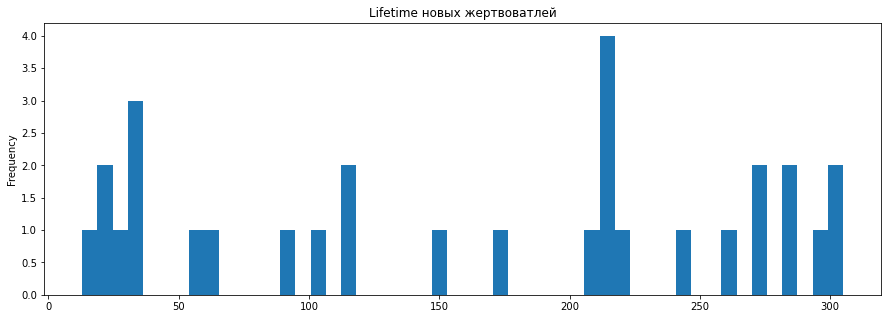

In [140]:
#df_new['lifetime'].plot(title='Lifetime новых жертвоватлей', figsize=(15,5), kind='bar')
df_new['lifetime'].plot(title='Lifetime новых жертвоватлей', figsize=(15,5), kind='hist', bins=50);


,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,period,first_donation,last_donation,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет
count,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000
mean,6.725146,6306.062164,1095.441599,945.854211,46.604029,0.450292,273.052632,57.983728,987.709515,714.412658,-0.081871,-262.392222,0.820664,0.034109,0.003759,0.141467,0.756144,0.109353,0.134503
std,3.791695,12429.336972,2297.816376,1916.879423,135.160587,0.498984,52.965390,39.826374,608.492024,613.845031,1.276147,5893.531514,0.358992,0.126056,0.039704,0.310676,0.419103,0.296884,0.342194
min,2.000000,90.000000,10.000000,10.000000,0.000000,0.000000,182.000000,9.000000,233.551131,19.421409,-7.000000,-27550.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,800.000000,180.666667,150.000000,23.876380,0.000000,219.000000,27.727273,460.425147,188.765813,0.000000,-200.000000,1.000000,0.000000,0.000000,0.000000,0.693182,0.000000,0.000000
50%,6.000000,2100.000000,366.666667,300.000000,28.237775,0.000000,274.000000,39.400000,865.509141,603.352786,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,10.000000,5200.000000,963.920000,1000.000000,28.237798,1.000000,310.500000,73.066667,1166.142329,897.319499,0.000000,95.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,28.000000,90000.000000,15000.000000,15000.000000,928.437810,1.000000,365.000000,182.500000,2532.251224,2258.248064,6.000000,60000.000000,1.000000,0.666667,0.500000,1.000000,1.000000,1.000000,1.000000


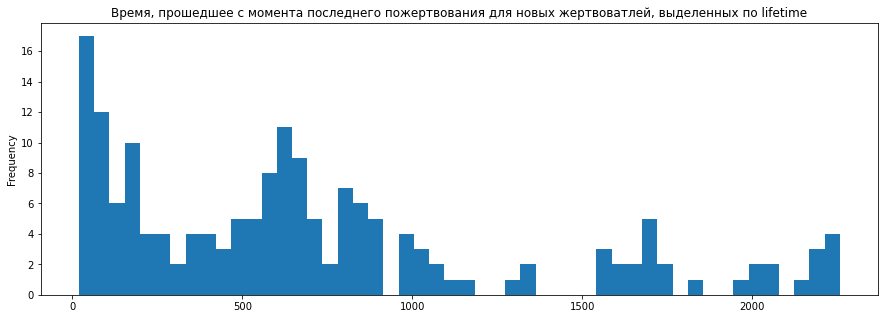

In [141]:
#Выделим новых жертвователей в отдельный датасет по lifetime
df_new1 = df_id[(df_id['lifetime']>=182) & (df_id['lifetime']<=365)]
display(df_new1.describe())
df_new1['last_donation'].plot(title='Время, прошедшее с момента последнего пожертвования для новых жертвоватлей, выделенных по lifetime', figsize=(15,5), kind='hist', bins=50);

**Вывод:** Для дальнейшей работы оставим первый способ выделения новых жертвователей.

### Постоянные жертвователи
Условия:
* первый платеж совершен более года назад;)
* lifetime более года


In [142]:
df_regular = df_id1[(df_id1['lifetime']>365) & (df_id1['first_donation']>)]
df_regular.describe()

,donations_count,donations_sum,donations_mean,donations_median,last_email_activity,is_reccurent,lifetime,period,first_donation,last_donation,count_lt_diff,total_lt_diff,пожертвование,sms_purpose,именное пожертвование,назнчение не указано,банковские карты,sms_channel,прямые поступления на счет
count,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000
mean,18.673511,15355.425175,947.207376,841.892906,38.411499,0.632444,839.554415,96.767878,1274.134493,434.302606,0.305955,436.202136,0.893323,0.018066,0.003051,0.085560,0.878780,0.051102,0.070119
std,13.737178,31730.685980,1887.809331,1681.587932,93.166533,0.482635,439.994553,133.199450,627.406514,527.896101,2.718407,6550.460805,0.264488,0.089641,0.029576,0.237268,0.302626,0.187546,0.252136
min,2.000000,77.000000,20.000000,15.000000,0.000000,0.000000,366.000000,7.644737,416.111259,18.118029,-15.000000,-44000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.500000,2775.000000,200.000000,200.000000,27.911774,0.000000,532.500000,29.196154,842.400211,42.236033,-1.000000,-275.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,17.000000,6800.000000,500.000000,500.000000,28.237775,1.000000,730.000000,35.478261,1063.196525,184.303886,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,27.000000,14000.000000,950.000000,1000.000000,28.237798,1.000000,1007.500000,100.791667,1838.332584,618.203973,1.000000,800.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,83.000000,398000.000000,27500.000000,27500.000000,852.005078,1.000000,2486.000000,823.500000,2583.918782,2153.494418,10.000000,57000.000000,1.000000,0.950000,0.538462,1.000000,1.000000,1.000000,1.000000
